In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for CI testing
smoke_test = ('CI' in os.environ)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [ ]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [ ]:
import torch
import torch.nn as nn
import torch.distributions as dist


class BayesianRegression(nn.Module):
    def __init__(self, in_features, out_features):
        super(BayesianRegression, self).__init__()
        # Define model parameters
        self.weight_mu = nn.Parameter(torch.zeros(in_features, out_features, requires_grad=True))
        self.weight_rho = nn.Parameter(torch.zeros(in_features, out_features, requires_grad=True))
        self.bias_mu = nn.Parameter(torch.zeros(out_features, requires_grad=True))
        self.bias_rho = nn.Parameter(torch.zeros(out_features, requires_grad=True))
        # Number of samples for Monte Carlo estimation
        self.samples = 10

    def forward(self, x):
        # Initialize tensors to store sampled weights and biases
        weights = []
        biases = []

        for _ in range(self.samples):
            # Update variational distributions based on current parameter values
            weight_posterior = dist.Normal(self.weight_mu, torch.log1p(torch.exp(self.weight_rho)))
            bias_posterior = dist.Normal(self.bias_mu, torch.log1p(torch.exp(self.bias_rho)))
            # weight_posterior = dist.Normal(self.weight_mu, F.softplus(self.weight_rho))
            # bias_posterior = dist.Normal(self.bias_mu, F.softplus(self.bias_rho))
            # Sample each layer
            weight = weight_posterior.sample()
            bias = bias_posterior.sample()

            # Append sampled weights and biases
            weights.append(weight)
            biases.append(bias)

        # Stack sampled weights and biases along a new dimension
        weights = torch.stack(weights, dim=-1)
        biases = torch.stack(biases, dim=-1)

        # Calculate mean of sampled weights and biases
        weight_mean = weights.mean(dim=-1)
        bias_mean = biases.mean(dim=-1)

        # Calculate KL divergence
        kl_weight = -0.5 * torch.sum(1 + 2 * self.weight_rho - self.weight_mu ** 2 - torch.exp(2 * self.weight_rho))
        kl_bias = -0.5 * torch.sum(1 + 2 * self.bias_rho - self.bias_mu ** 2 - torch.exp(2 * self.bias_rho))
        kl = kl_weight + kl_bias

        # Make predictions with mean weight and bias
        y_hat = torch.mm(x, weight_mean) + bias_mean.unsqueeze(0).expand(x.shape[0], -1)
        return y_hat, kl / self.samples


In [ ]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                    dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model
linear_reg_model = BayesianRegression(3, 1)


class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()

    def forward(self, y_pred, y_target, kl):
        mse_loss = nn.functional.mse_loss(y_pred, y_target)
        return mse_loss + kl


# Define loss and optimizer
loss_fn = CustomMSELoss()
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)

# Print parameters
print(list(linear_reg_model.named_parameters()))

num_iterations = 4000 if not smoke_test else 2


def gradient_check(model, loss_fn, x, y):
    # Ensure that the model is in training mode
    model.train()
    # Forward pass
    y_pred, kl = model(x)
    loss = -loss_fn(y_pred.squeeze(), y, kl)

    # Backward pass
    model.zero_grad()
    loss.backward(retain_graph=True)

    # Check gradients using PyTorch's gradcheck
    input_params = tuple(p for p in model.parameters())
    check = torch.autograd.gradcheck(loss_fn, (y_pred.squeeze(), y, kl), eps=1e-6, atol=1e-4)

    print(f"Gradient check passed: {check}")


def train():
    linear_reg_model.train()
    y_pred, kl = linear_reg_model(x_data)
    mse_loss = loss_fn(y_pred.squeeze(), y_data, kl)
    elbo = mse_loss + kl
    optim.zero_grad()
    elbo.backward(retain_graph=True)
    optim.step()
    return elbo  # Return ELBO as a positive value for interpretability


gradient_check(linear_reg_model, loss_fn, x_data, y_data)

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

Epoch 0/10000, Loss: 746855.375


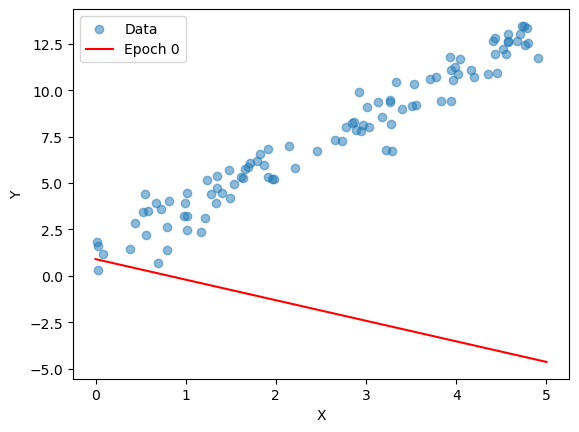

Epoch 100/10000, Loss: 294129.53125


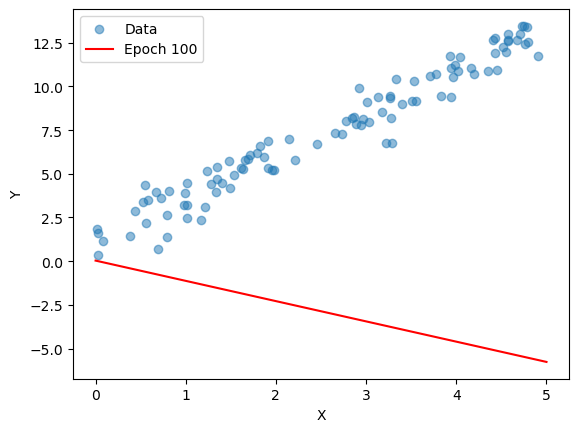

Epoch 200/10000, Loss: 171196.171875


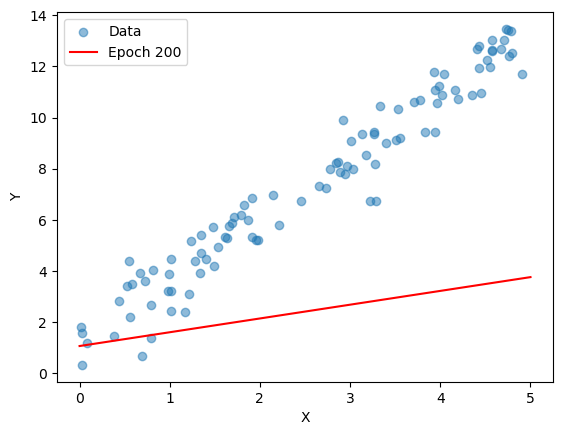

Epoch 300/10000, Loss: 180135.515625


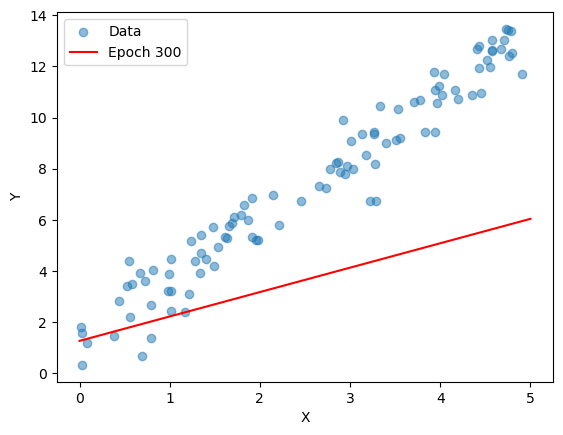

Epoch 400/10000, Loss: 49517.0390625


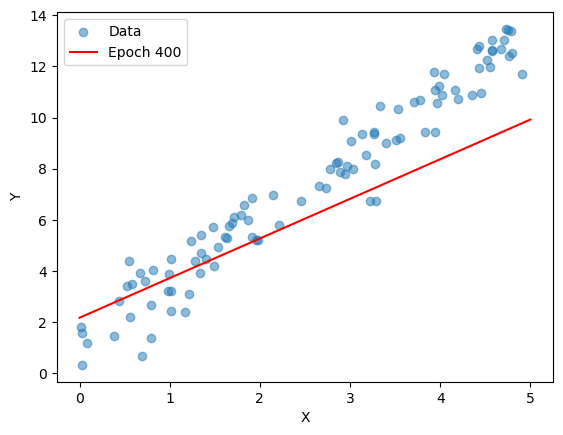

Epoch 500/10000, Loss: 55707.5703125


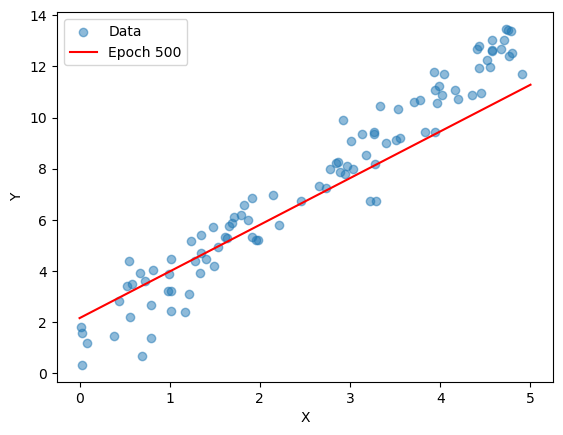

Epoch 600/10000, Loss: 45973.29296875


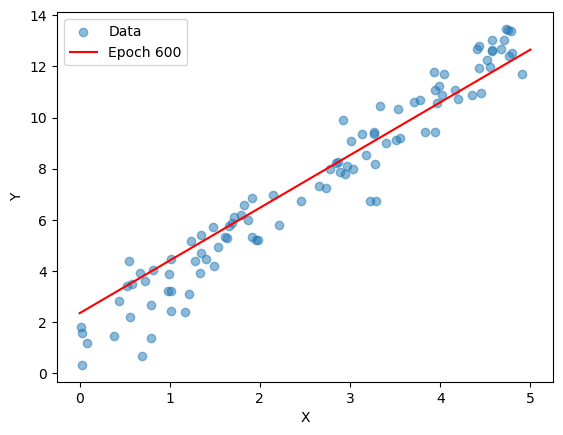

Epoch 700/10000, Loss: 7825.2705078125


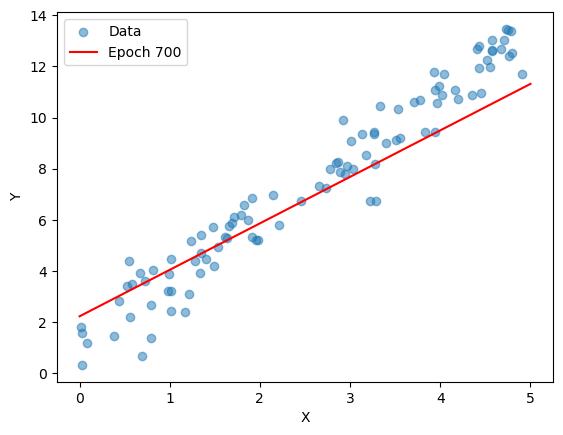

Epoch 800/10000, Loss: 17552.841796875


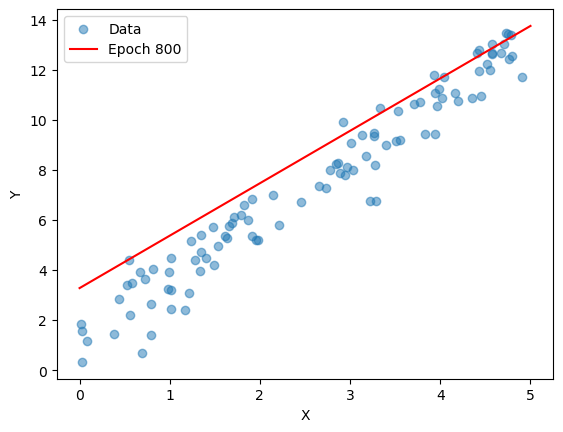

Epoch 900/10000, Loss: 4841.01953125


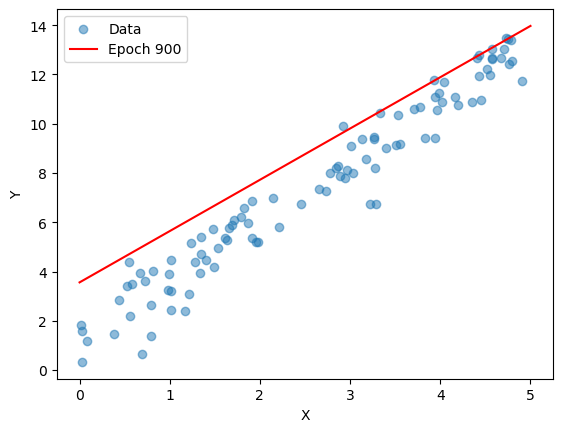

Epoch 1000/10000, Loss: 5188.96533203125


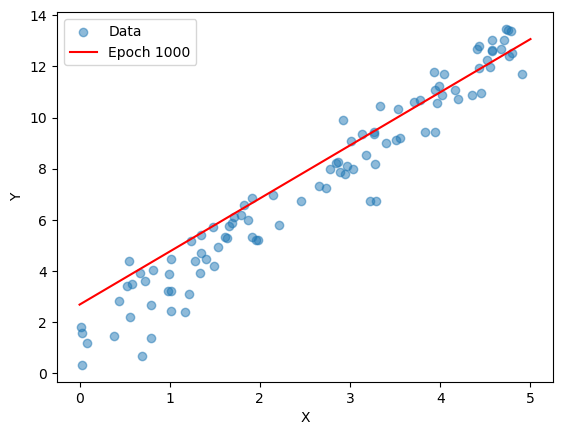

Epoch 1100/10000, Loss: 4877.15283203125


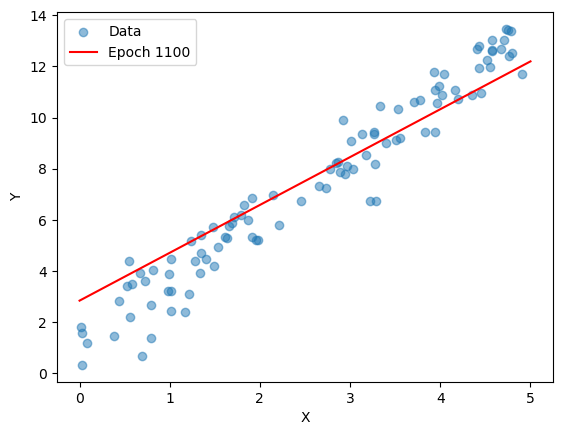

Epoch 1200/10000, Loss: 6346.16748046875


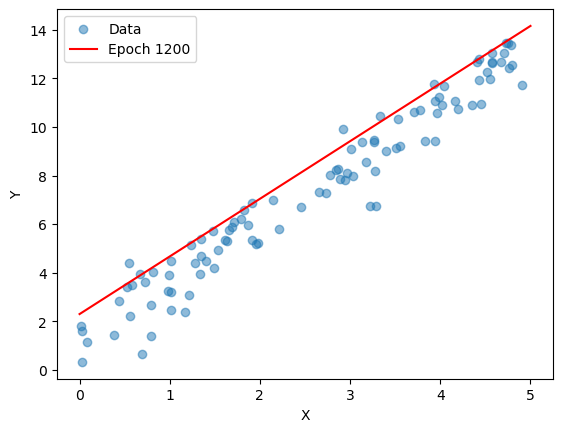

Epoch 1300/10000, Loss: 5330.20654296875


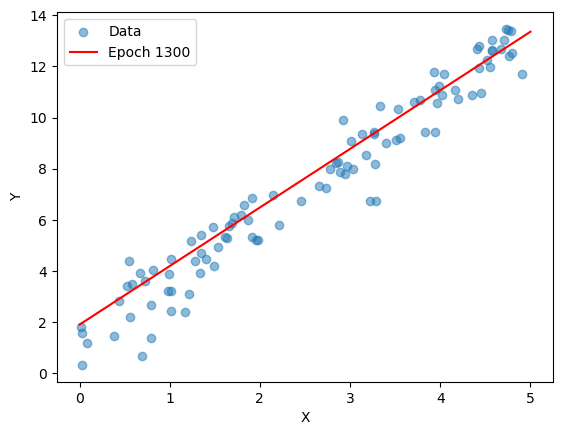

Epoch 1400/10000, Loss: 6963.10205078125


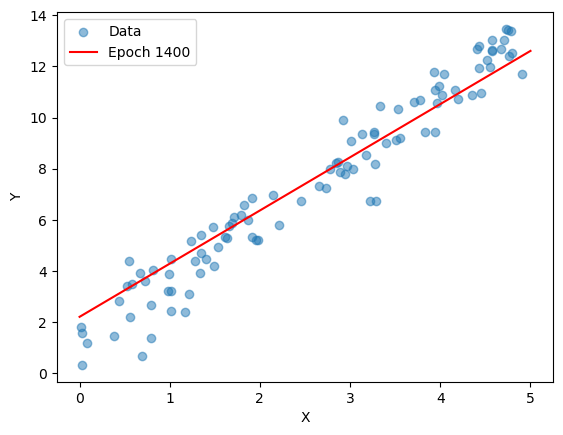

Epoch 1500/10000, Loss: 3800.34375


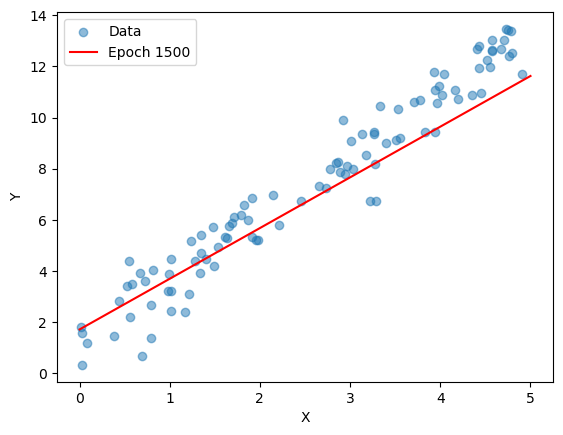

Epoch 1600/10000, Loss: 4275.42626953125


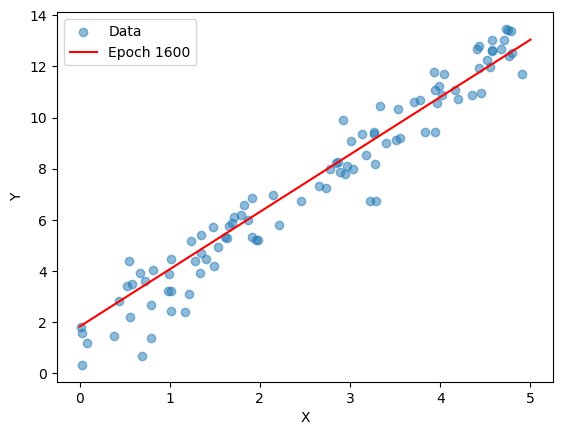

Epoch 1700/10000, Loss: 4295.41845703125


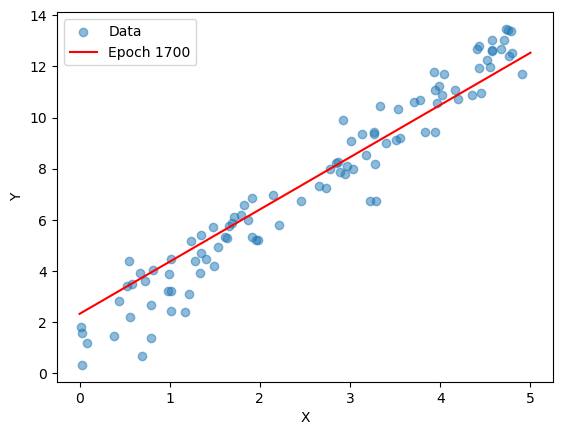

Epoch 1800/10000, Loss: 5540.3662109375


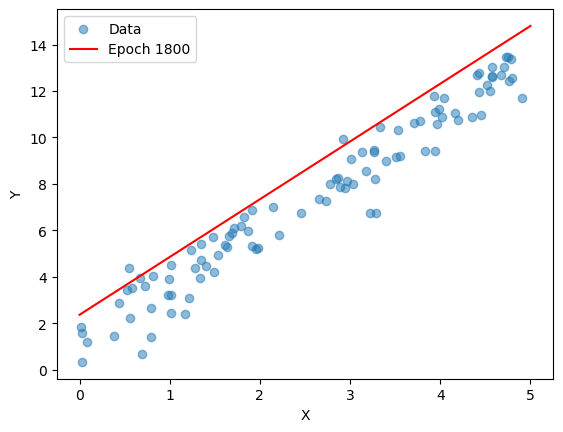

Epoch 1900/10000, Loss: 9802.900390625


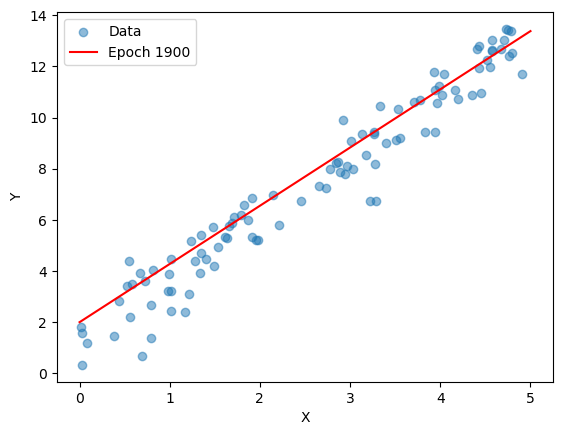

Epoch 2000/10000, Loss: 3907.9248046875


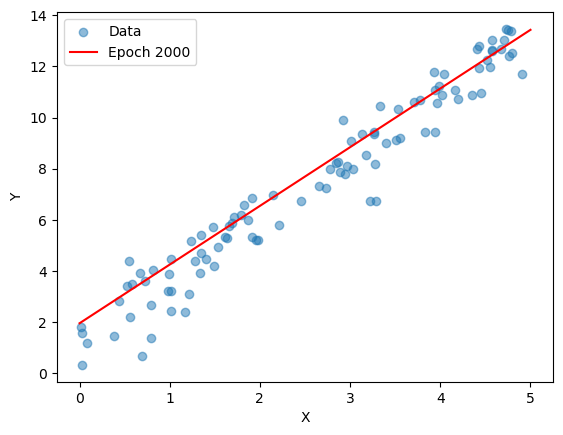

Epoch 2100/10000, Loss: 3826.148681640625


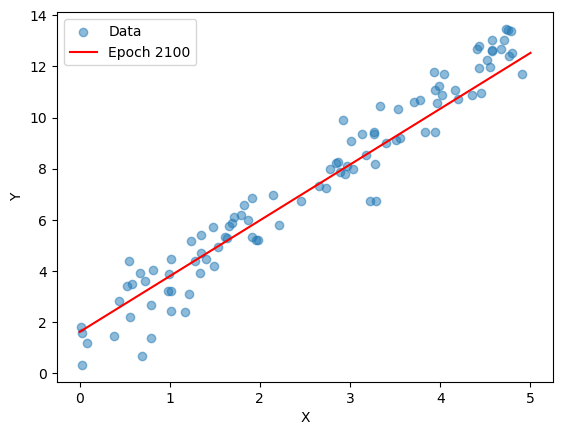

Epoch 2200/10000, Loss: 3278.33447265625


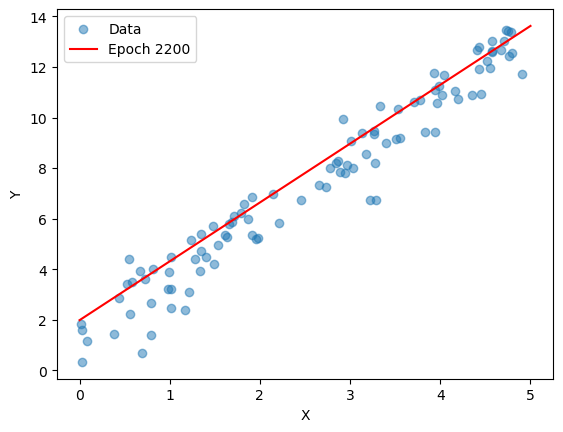

Epoch 2300/10000, Loss: 3525.000244140625


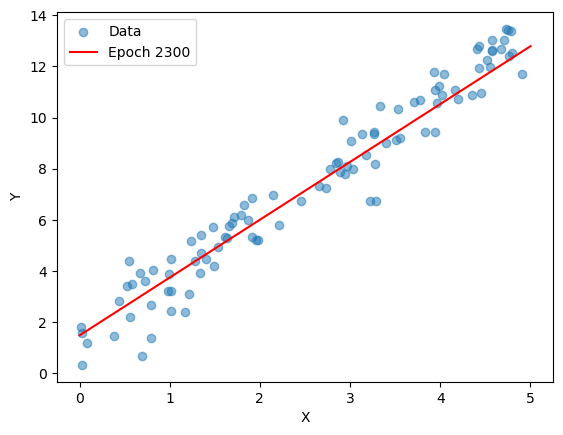

Epoch 2400/10000, Loss: 5790.0693359375


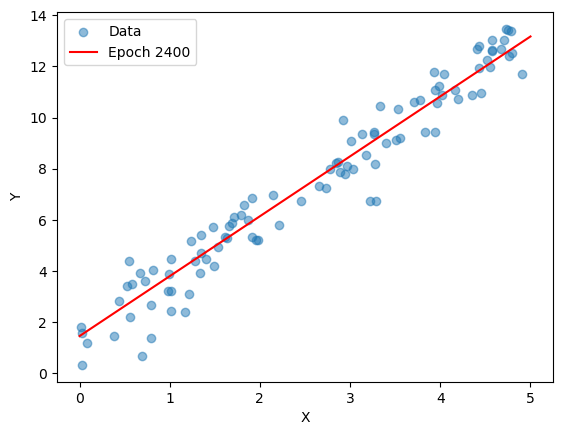

Epoch 2500/10000, Loss: 3575.6552734375


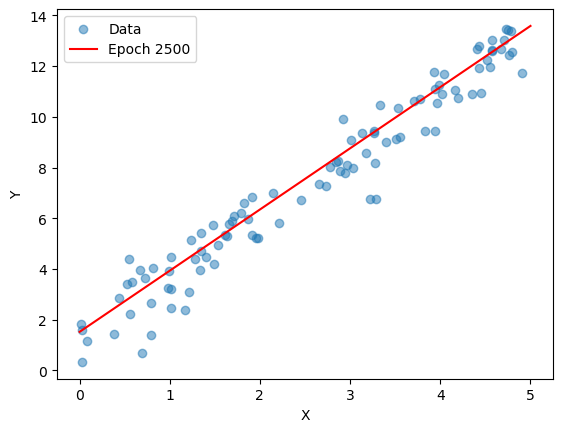

Epoch 2600/10000, Loss: 3370.43408203125


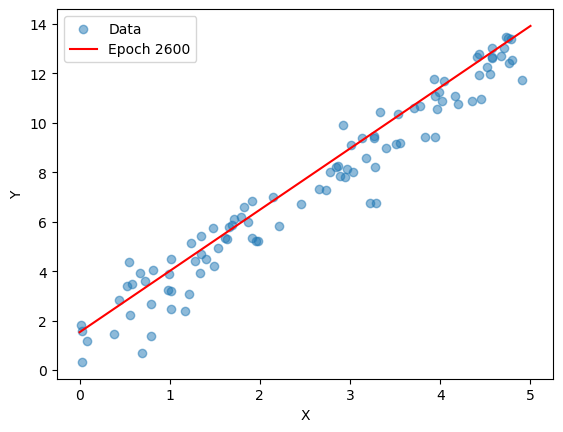

Epoch 2700/10000, Loss: 3173.140869140625


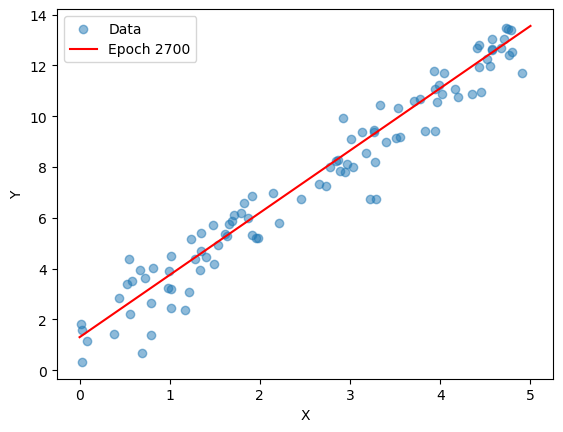

Epoch 2800/10000, Loss: 3213.314453125


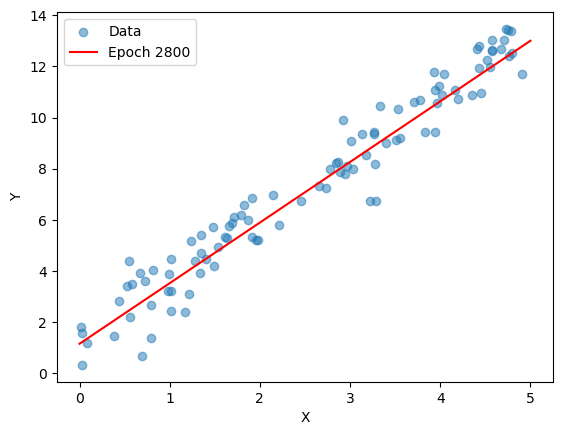

Epoch 2900/10000, Loss: 3753.390625


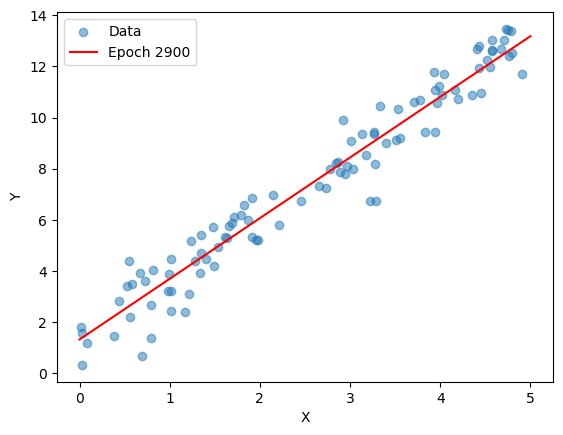

Epoch 3000/10000, Loss: 3241.059814453125


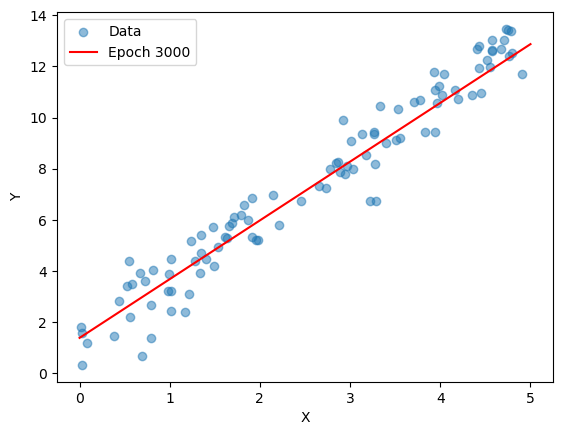

Epoch 3100/10000, Loss: 3489.724609375


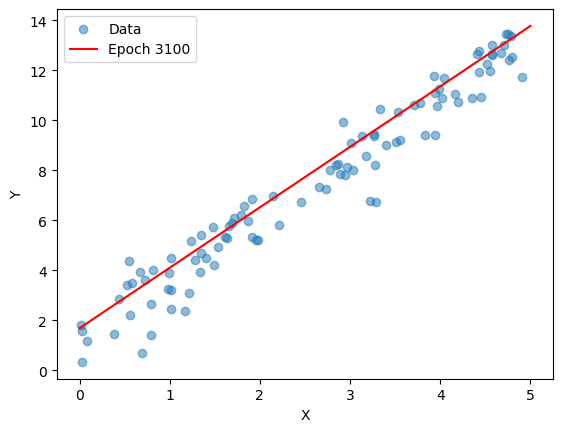

Epoch 3200/10000, Loss: 3271.525634765625


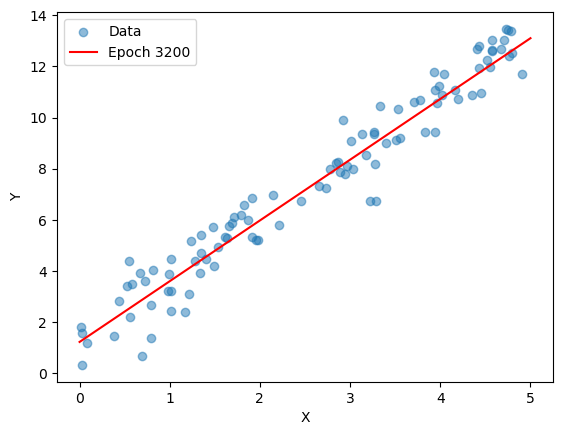

Epoch 3300/10000, Loss: 3251.600341796875


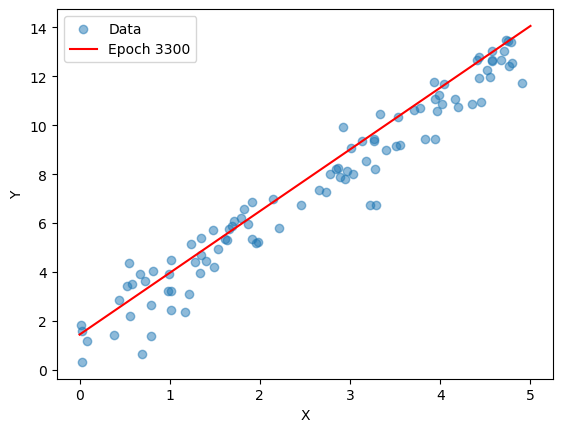

Epoch 3400/10000, Loss: 4617.8623046875


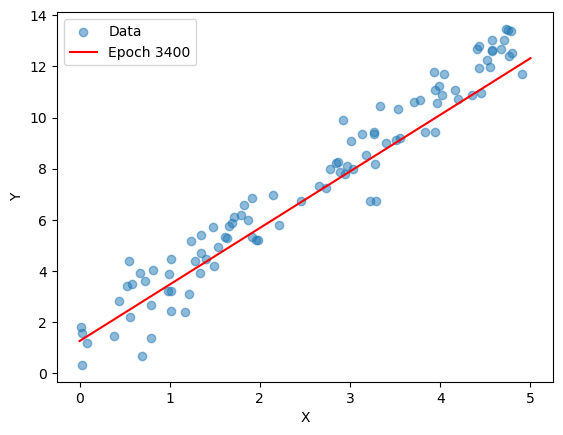

Epoch 3500/10000, Loss: 3472.211181640625


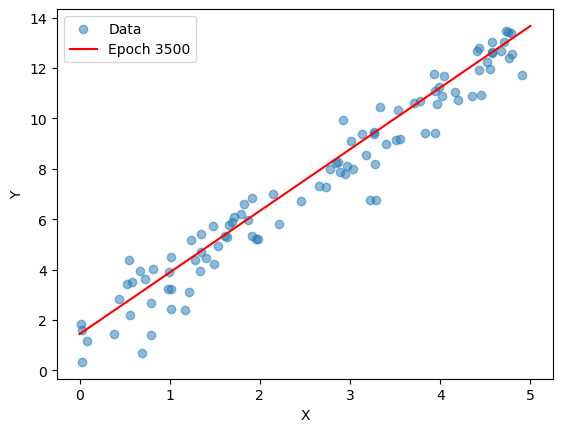

Epoch 3600/10000, Loss: 3181.917724609375


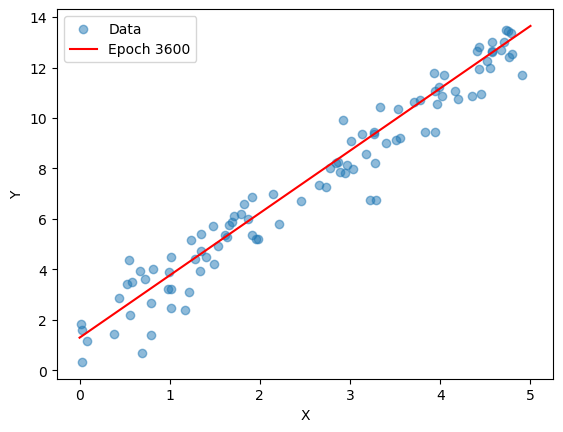

Epoch 3700/10000, Loss: 3217.690673828125


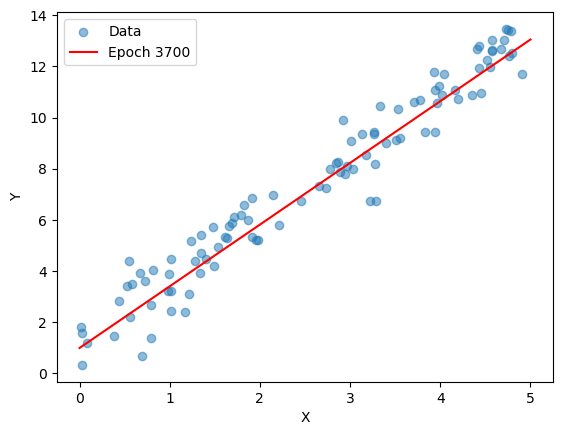

Epoch 3800/10000, Loss: 3399.34814453125


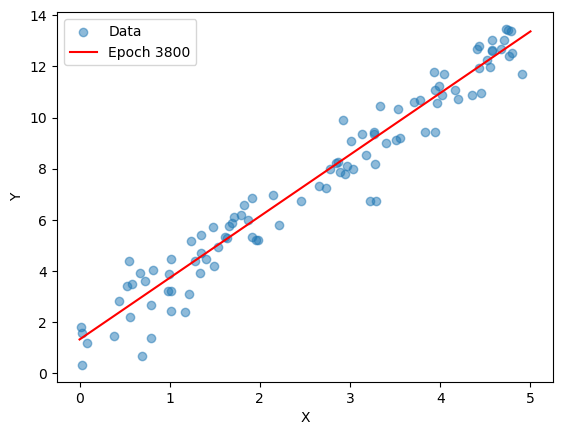

Epoch 3900/10000, Loss: 3484.96630859375


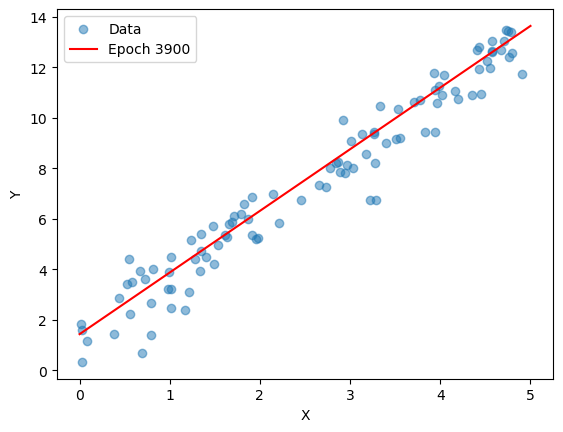

Epoch 4000/10000, Loss: 3408.299560546875


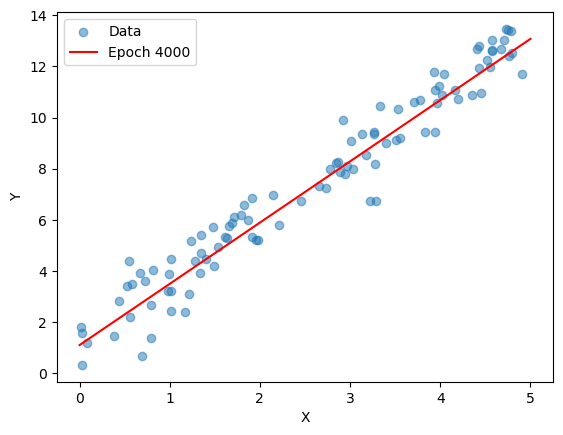

Epoch 4100/10000, Loss: 3170.431884765625


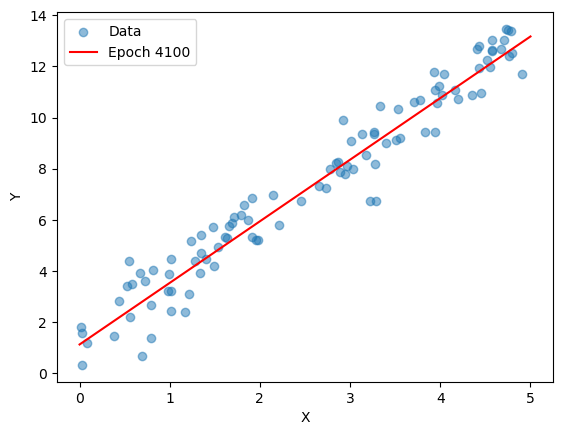

Epoch 4200/10000, Loss: 3215.578369140625


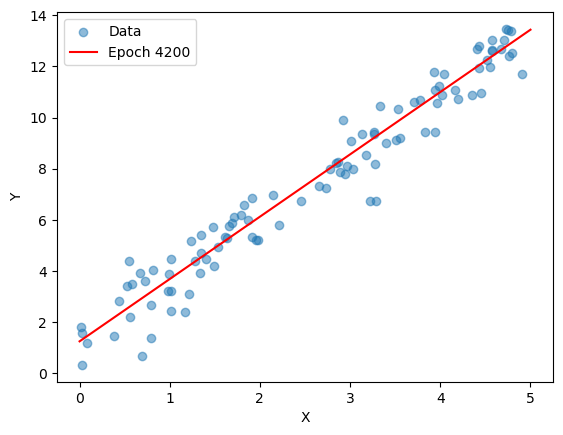

Epoch 4300/10000, Loss: 3173.077392578125


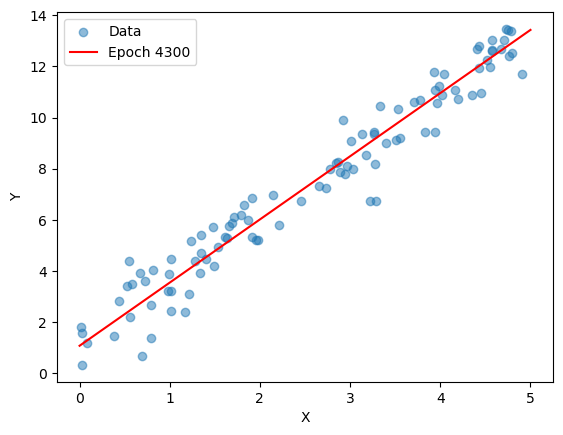

Epoch 4400/10000, Loss: 3645.419677734375


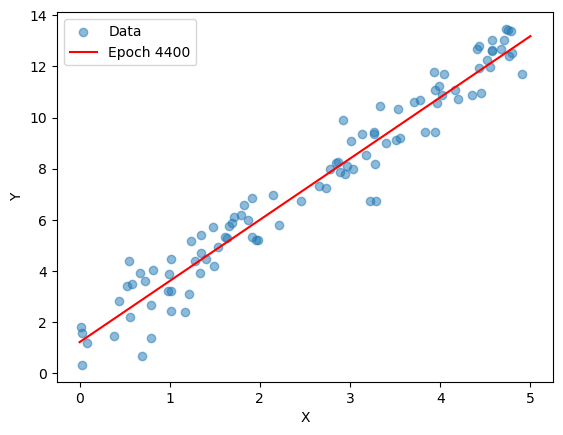

Epoch 4500/10000, Loss: 3191.681640625


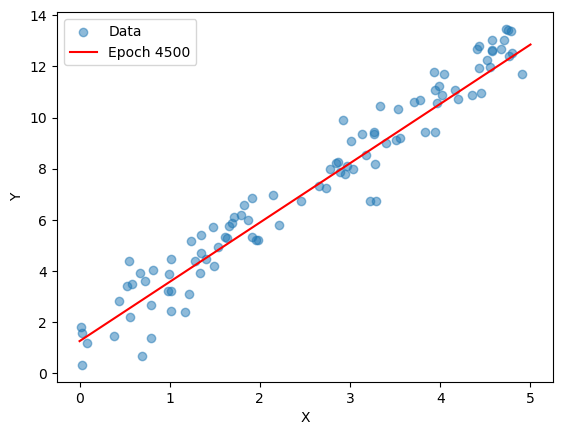

Epoch 4600/10000, Loss: 3241.491943359375


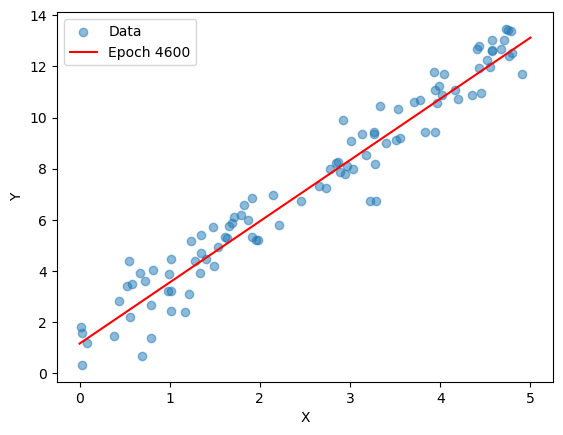

Epoch 4700/10000, Loss: 3282.819091796875


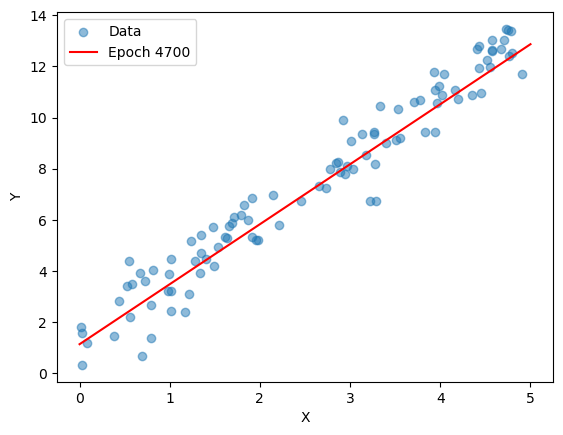

Epoch 4800/10000, Loss: 3570.799560546875


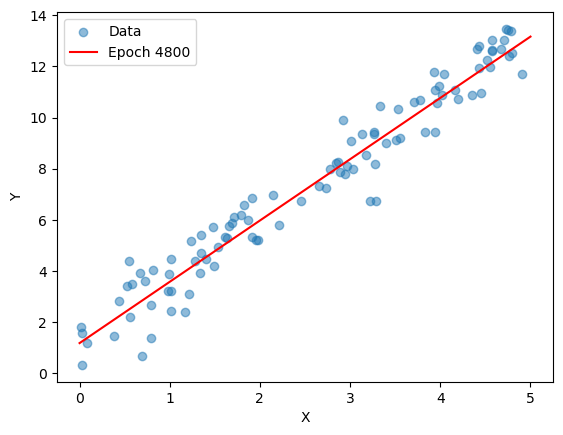

Epoch 4900/10000, Loss: 3196.083740234375


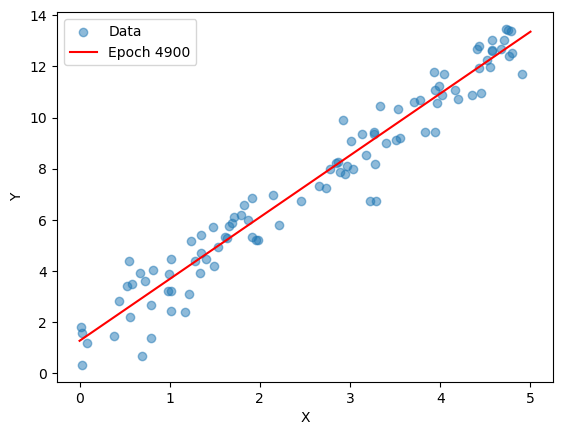

Epoch 5000/10000, Loss: 3178.560302734375


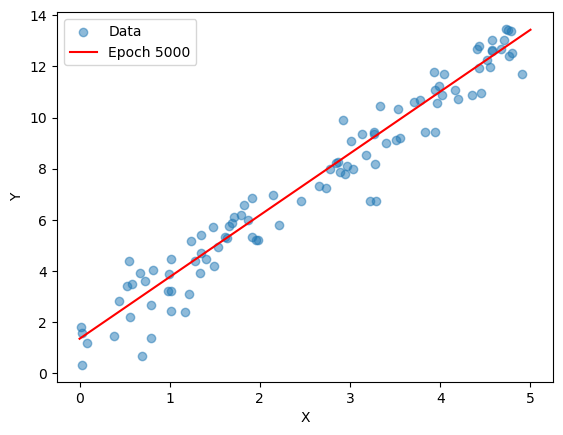

Epoch 5100/10000, Loss: 3670.1845703125


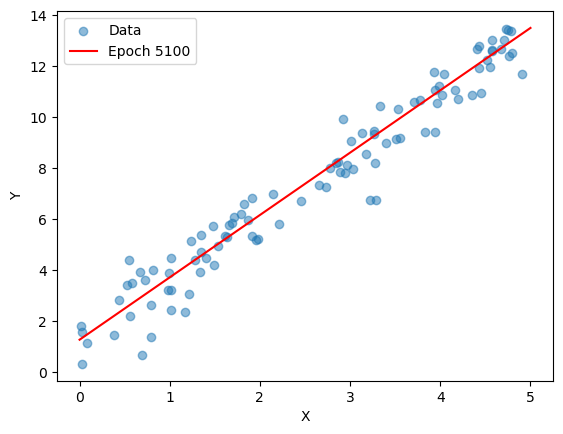

Epoch 5200/10000, Loss: 3186.524658203125


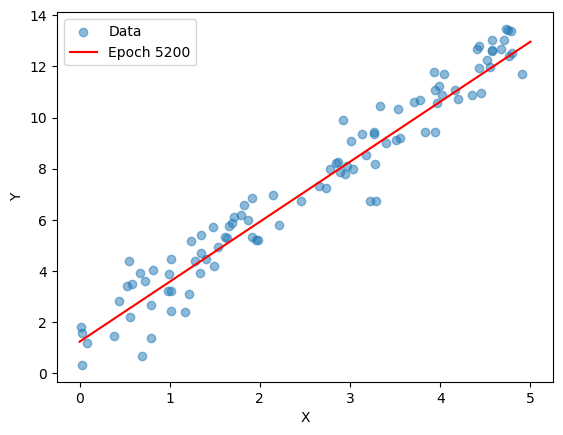

Epoch 5300/10000, Loss: 3175.692138671875


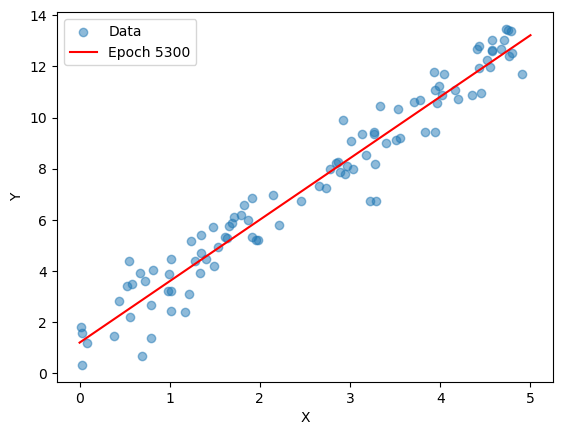

Epoch 5400/10000, Loss: 3169.509033203125


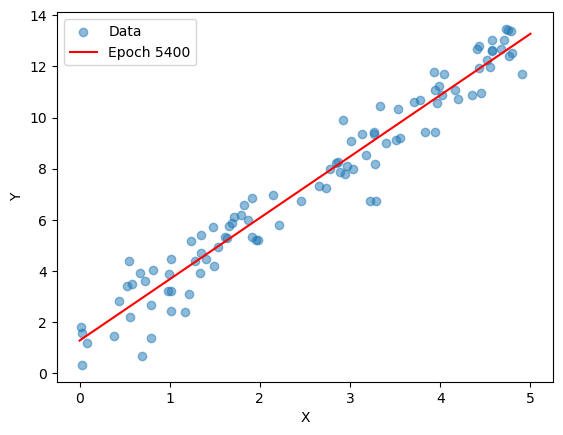

Epoch 5500/10000, Loss: 3172.1142578125


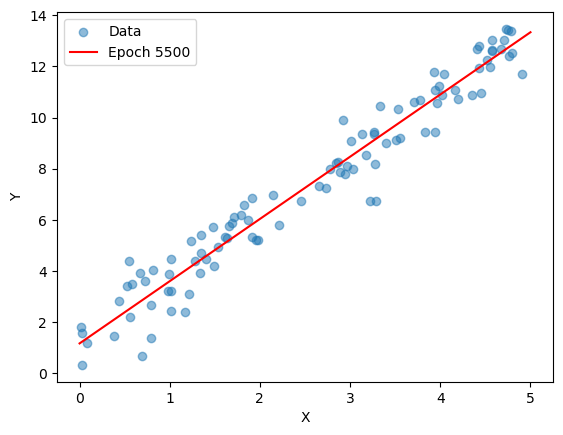

Epoch 5600/10000, Loss: 3269.31396484375


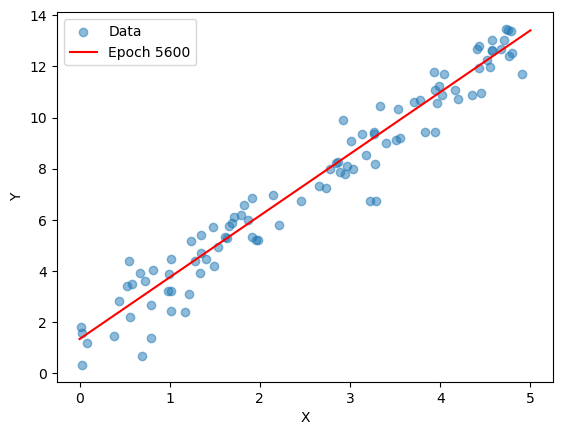

Epoch 5700/10000, Loss: 3199.201904296875


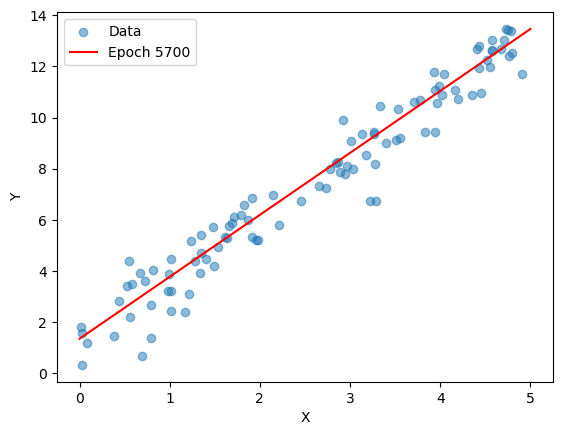

Epoch 5800/10000, Loss: 3171.176513671875


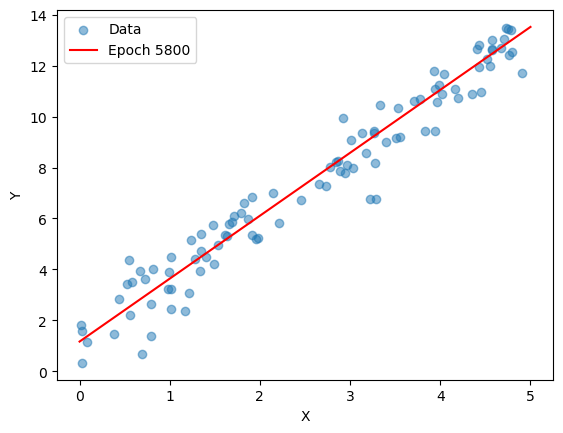

Epoch 5900/10000, Loss: 3184.543701171875


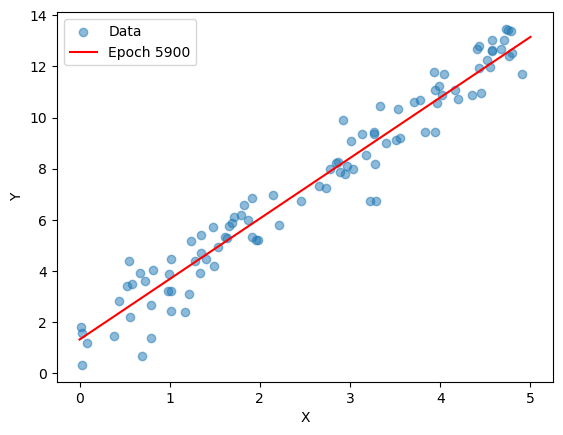

Epoch 6000/10000, Loss: 3178.522705078125


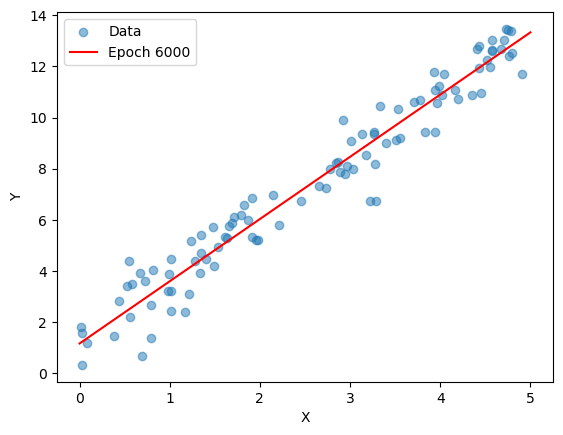

Epoch 6100/10000, Loss: 3182.54443359375


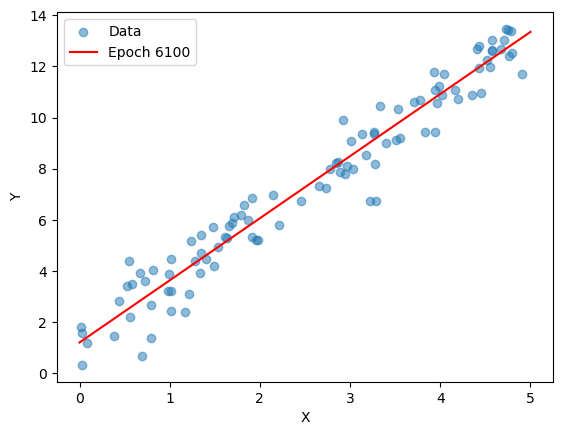

Epoch 6200/10000, Loss: 3189.873046875


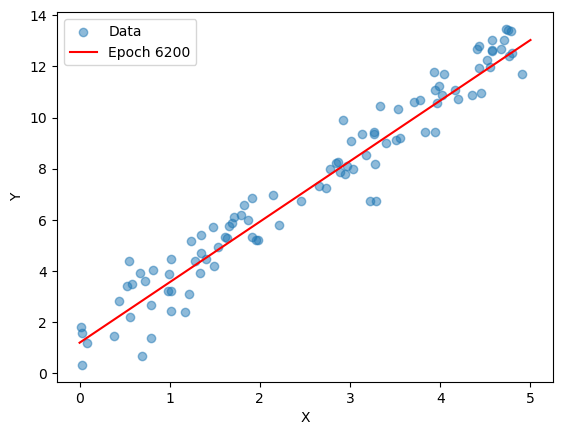

Epoch 6300/10000, Loss: 3187.297607421875


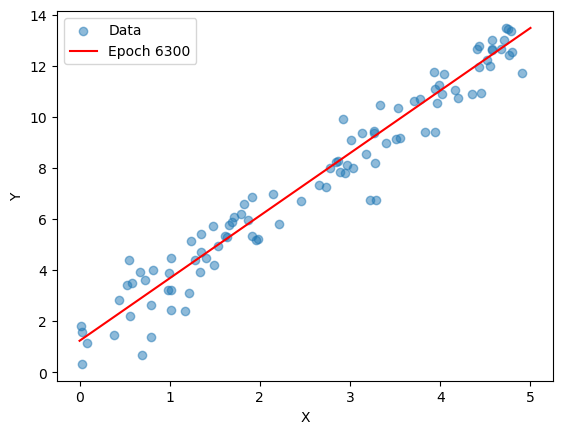

Epoch 6400/10000, Loss: 3168.66357421875


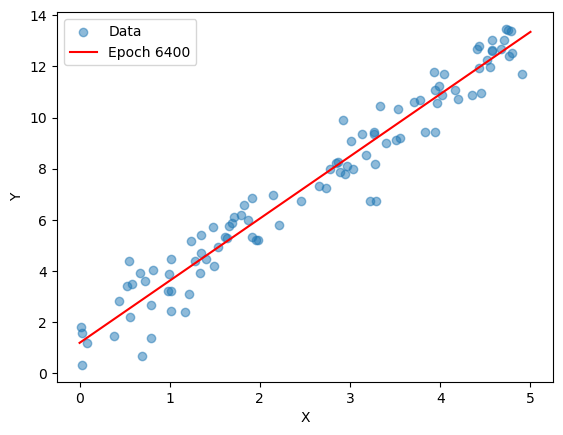

Epoch 6500/10000, Loss: 3226.969970703125


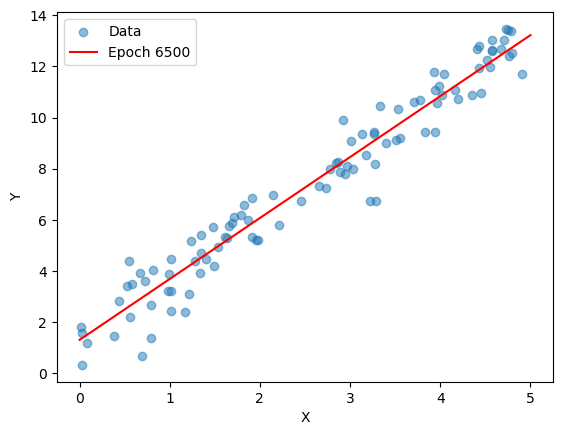

Epoch 6600/10000, Loss: 3195.974365234375


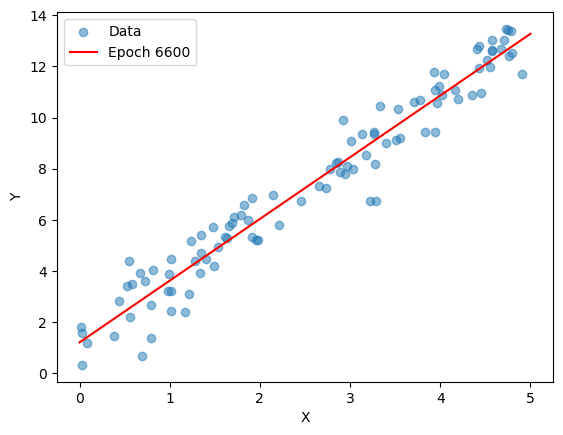

Epoch 6700/10000, Loss: 3178.079833984375


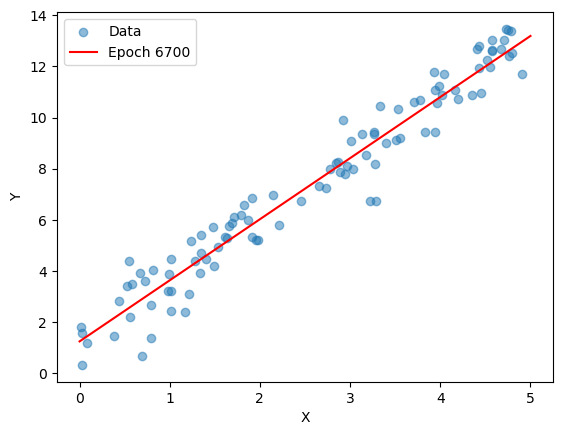

Epoch 6800/10000, Loss: 3193.059326171875


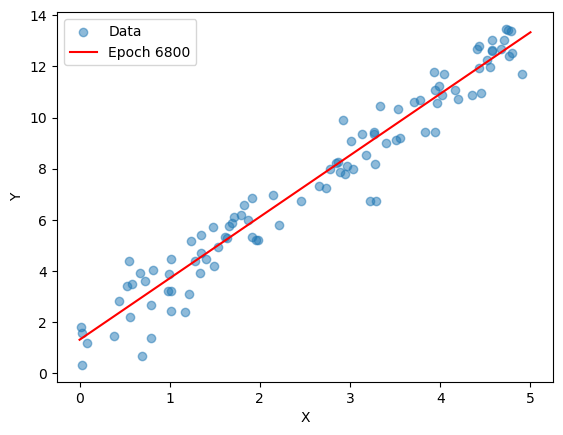

Epoch 6900/10000, Loss: 3168.654541015625


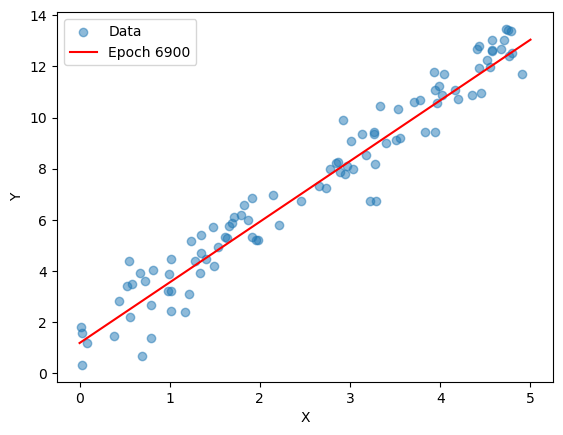

Epoch 7000/10000, Loss: 3168.573974609375


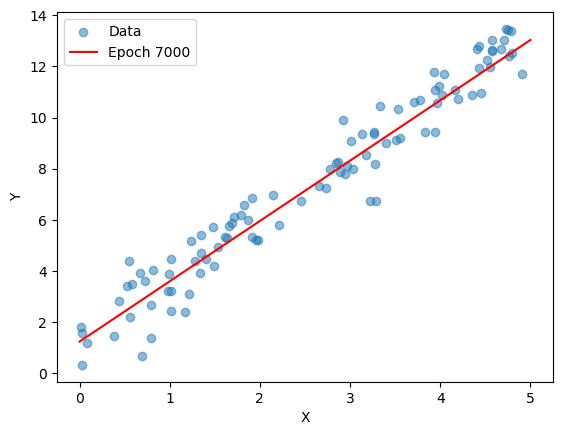

Epoch 7100/10000, Loss: 3363.69921875


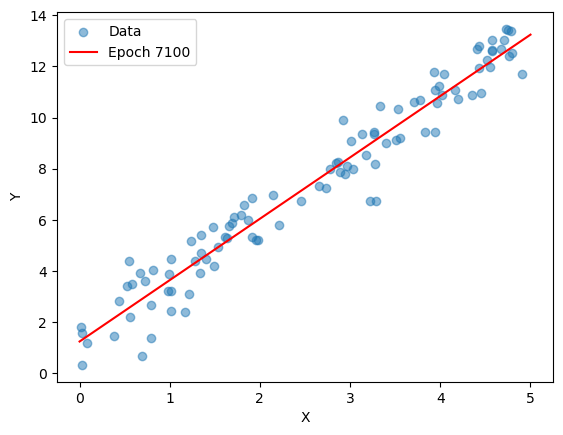

Epoch 7200/10000, Loss: 3259.915771484375


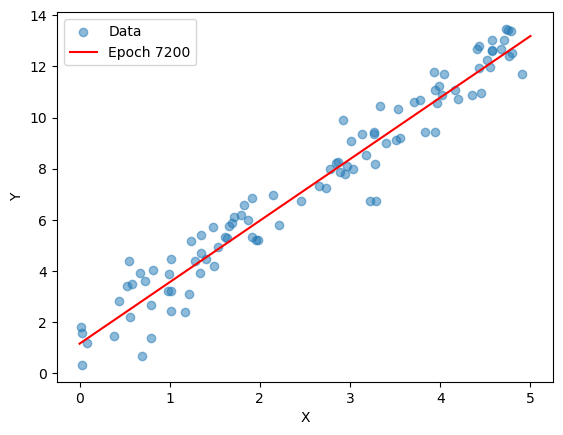

Epoch 7300/10000, Loss: 3191.434326171875


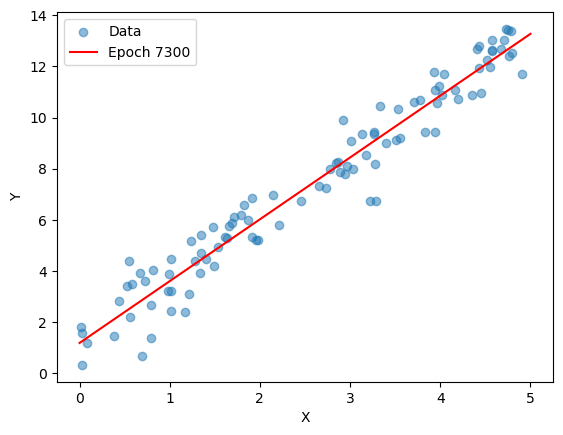

Epoch 7400/10000, Loss: 3185.503173828125


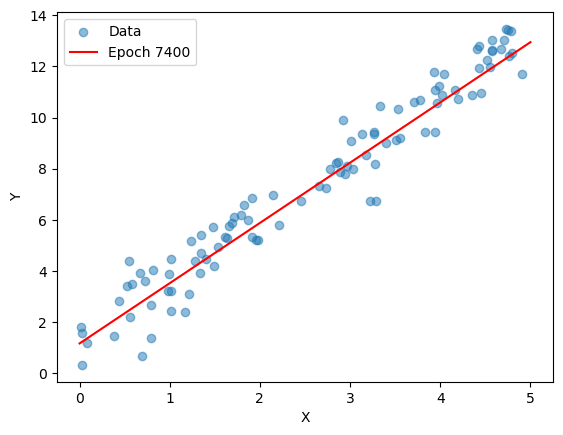

Epoch 7500/10000, Loss: 3177.04248046875


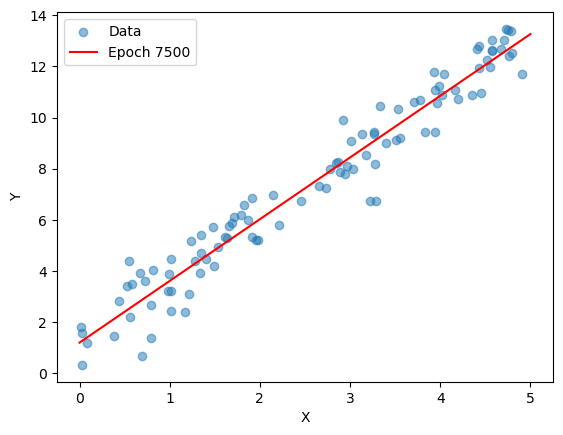

Epoch 7600/10000, Loss: 3181.424560546875


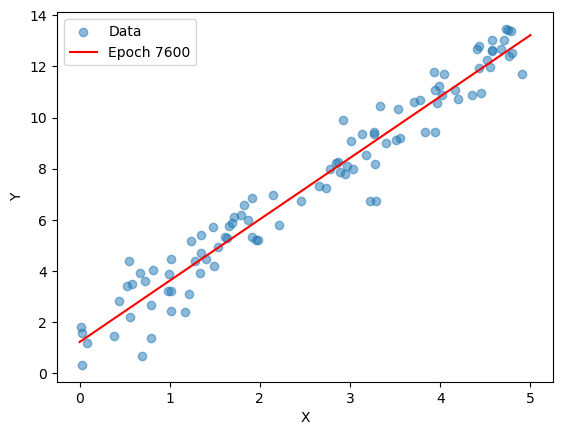

Epoch 7700/10000, Loss: 3265.342041015625


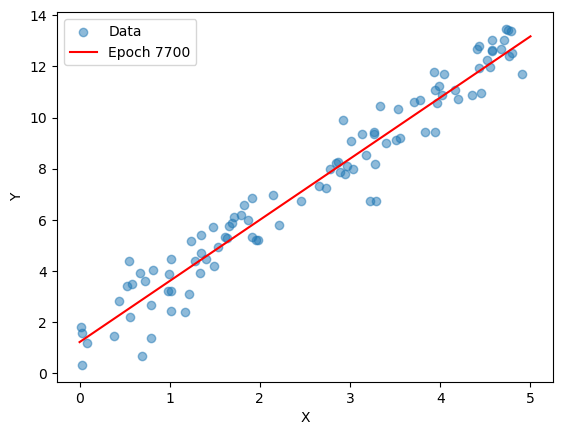

Epoch 7800/10000, Loss: 3174.060546875


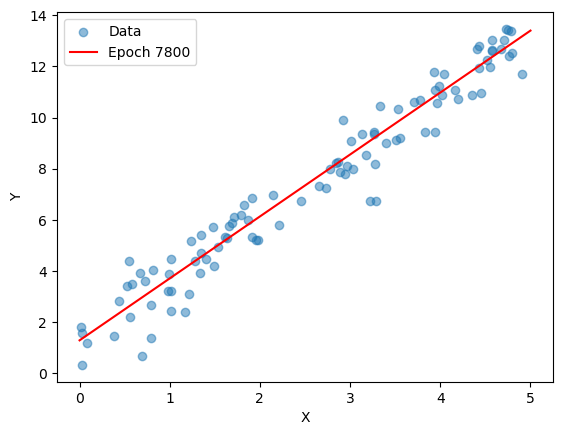

Epoch 7900/10000, Loss: 3170.556884765625


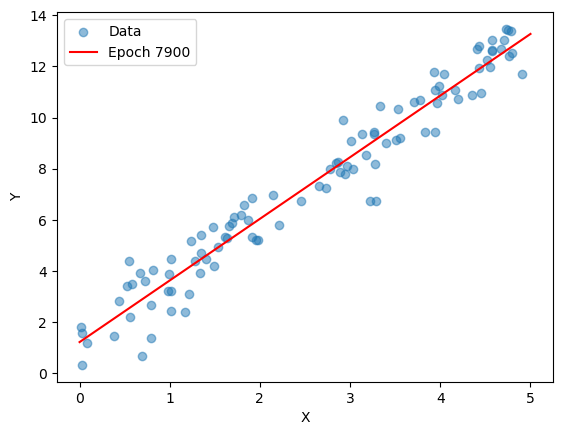

Epoch 8000/10000, Loss: 3173.002197265625


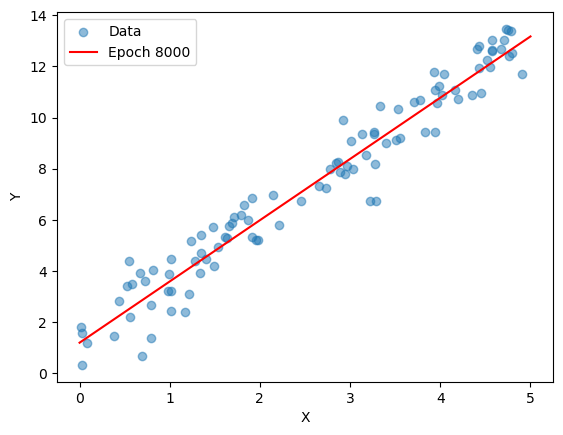

Epoch 8100/10000, Loss: 3167.386474609375


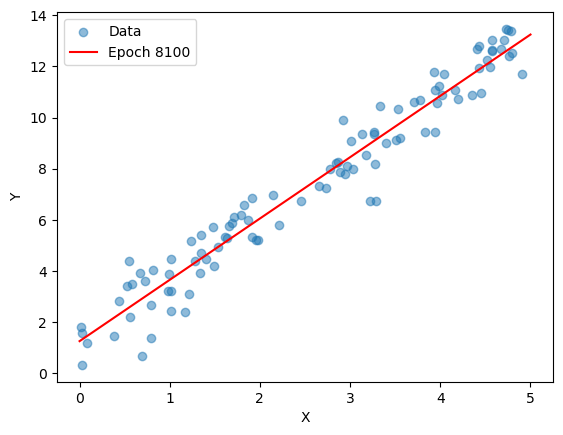

Epoch 8200/10000, Loss: 3179.564208984375


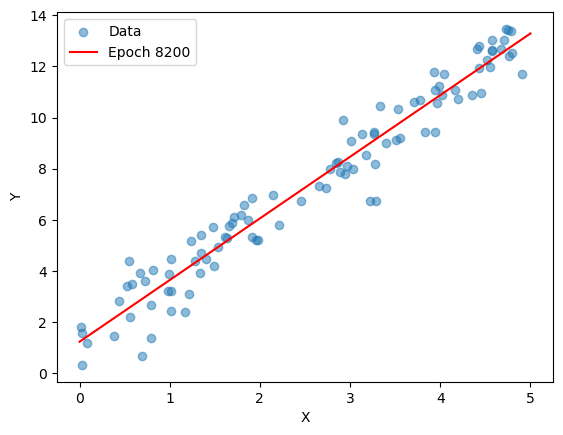

Epoch 8300/10000, Loss: 3185.82666015625


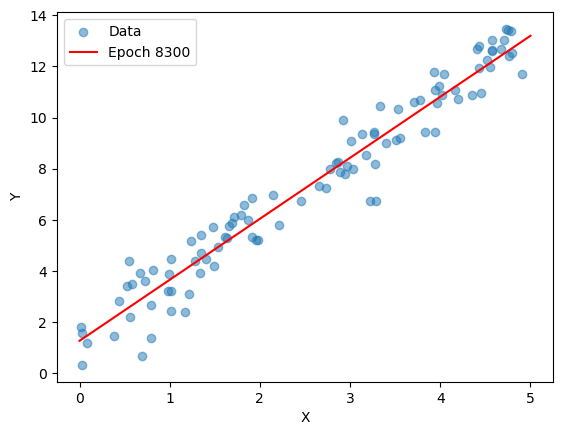

Epoch 8400/10000, Loss: 3176.498291015625


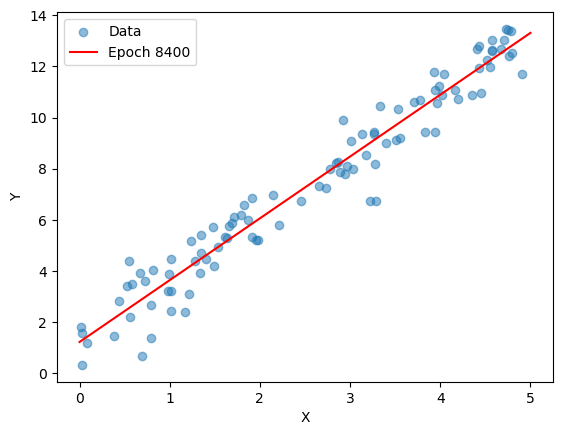

Epoch 8500/10000, Loss: 3177.013671875


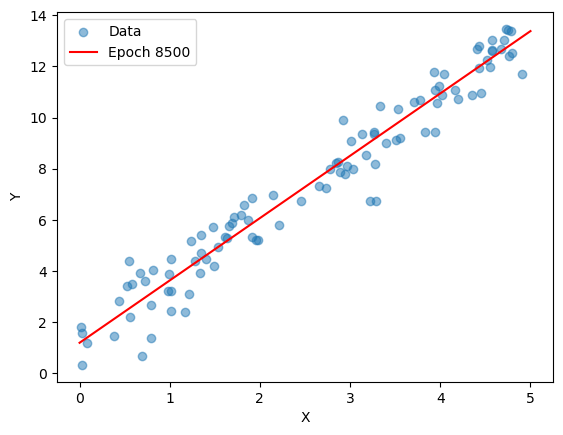

Epoch 8600/10000, Loss: 3173.37548828125


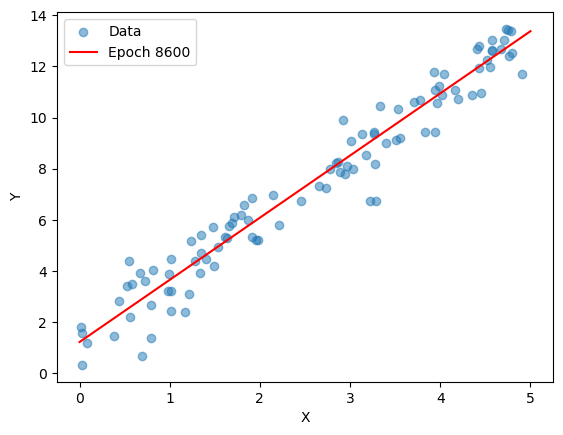

Epoch 8700/10000, Loss: 3187.03515625


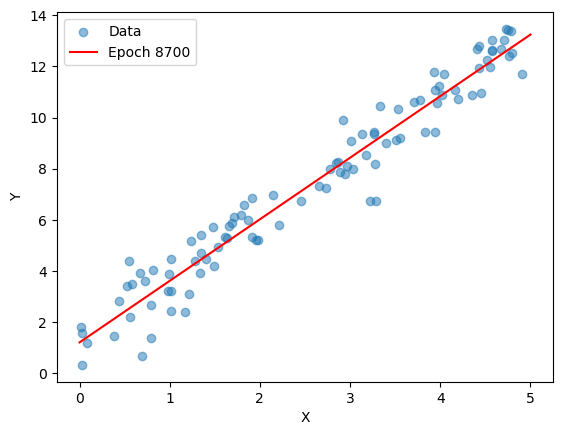

Epoch 8800/10000, Loss: 3183.957275390625


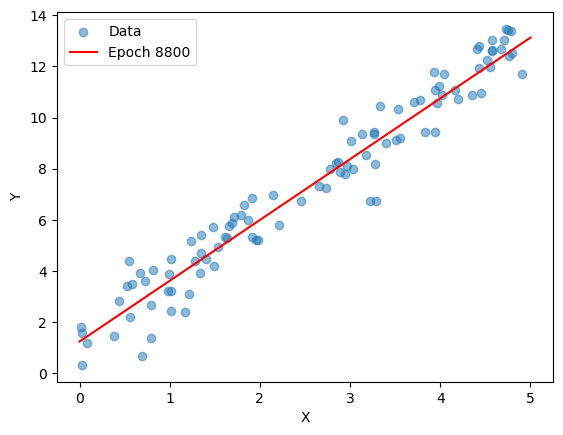

Epoch 8900/10000, Loss: 3170.01416015625


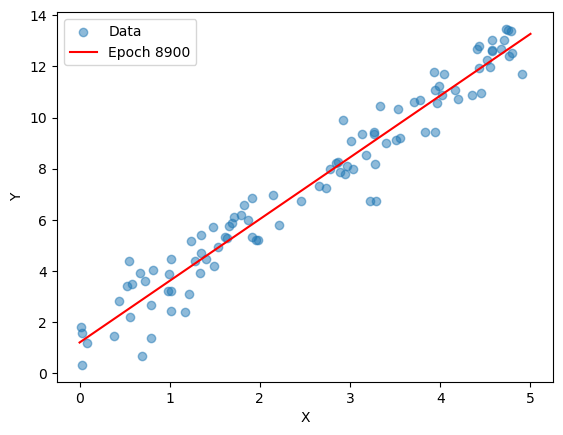

Epoch 9000/10000, Loss: 3176.591552734375


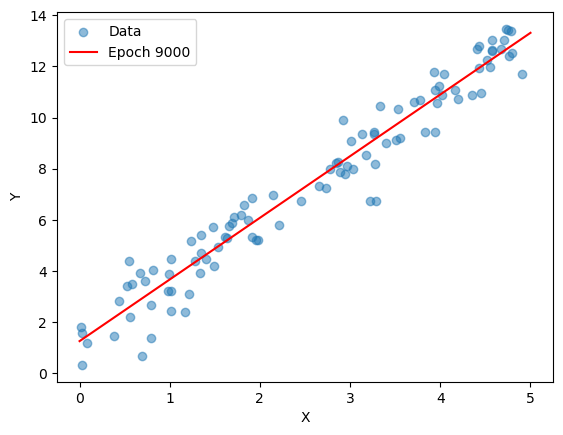

Epoch 9100/10000, Loss: 3166.862060546875


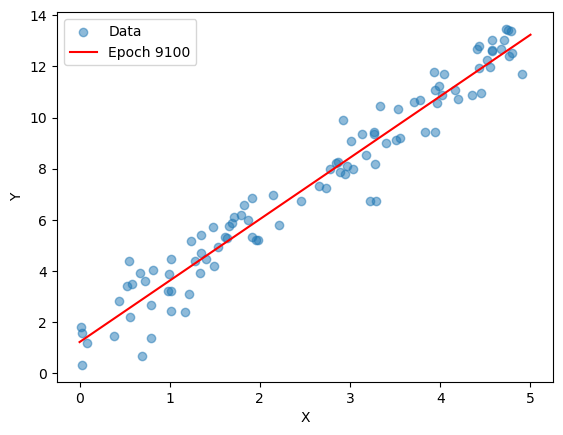

Epoch 9200/10000, Loss: 3174.33154296875


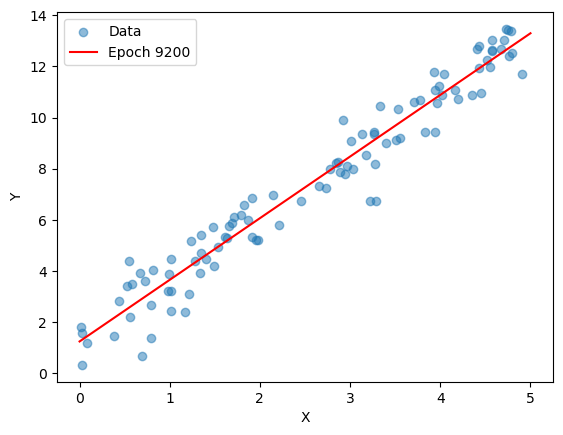

Epoch 9300/10000, Loss: 3177.037353515625


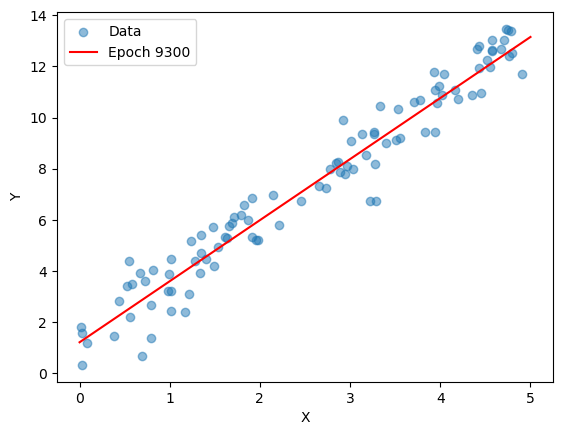

Epoch 9400/10000, Loss: 3169.116943359375


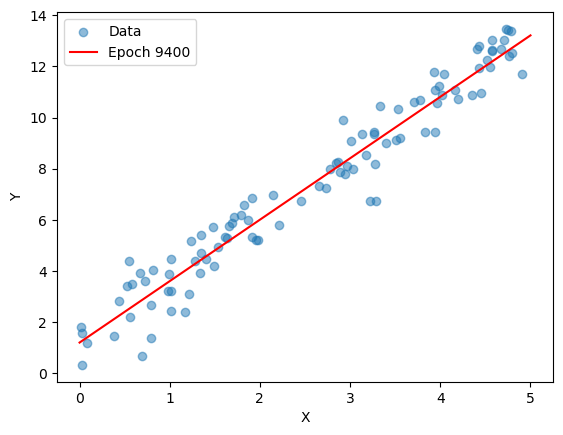

Epoch 9500/10000, Loss: 3171.978515625


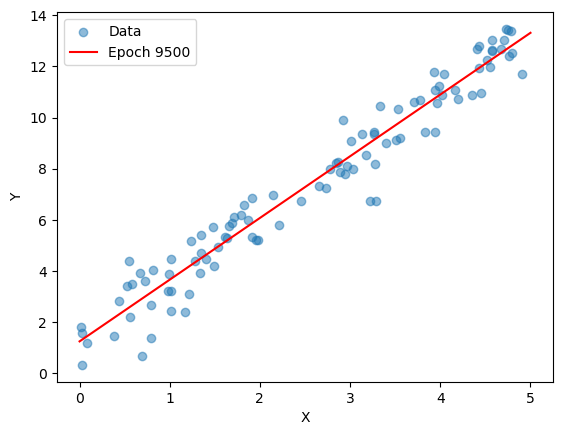

Epoch 9600/10000, Loss: 3166.665283203125


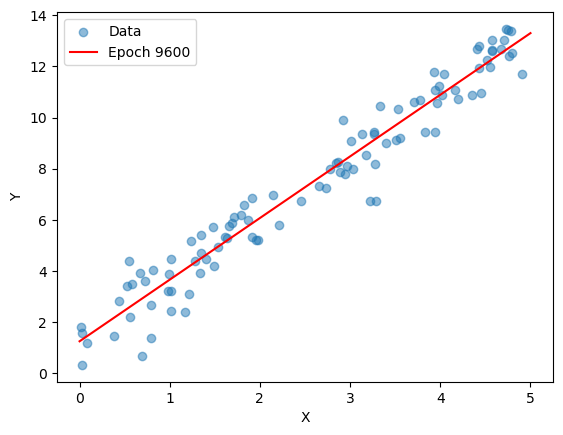

Epoch 9700/10000, Loss: 3184.365478515625


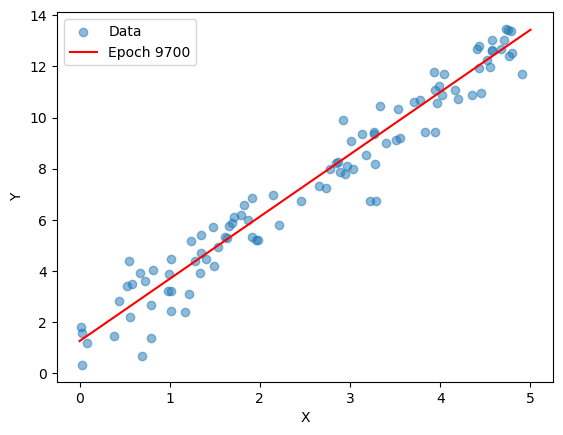

Epoch 9800/10000, Loss: 3166.973876953125


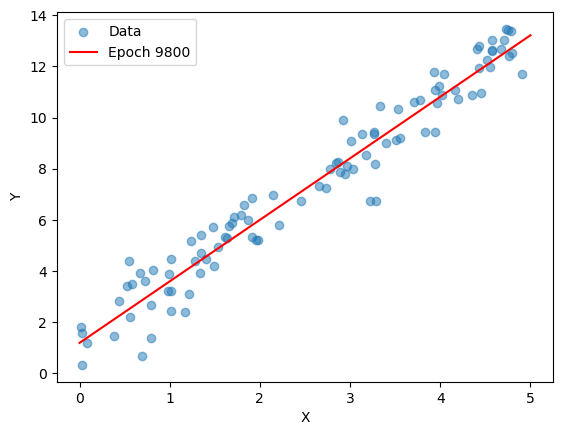

Epoch 9900/10000, Loss: 3169.564697265625


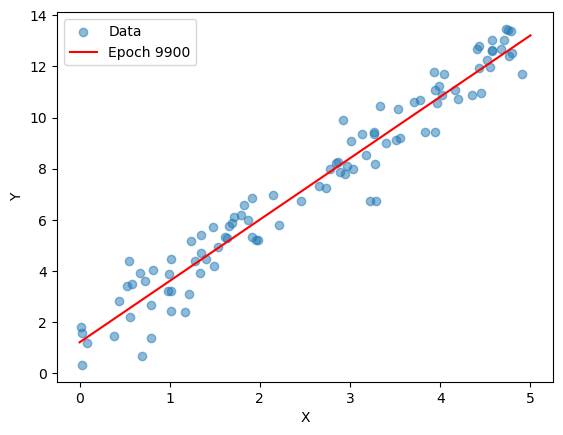

Epoch 9999/10000, Loss: 3167.29736328125


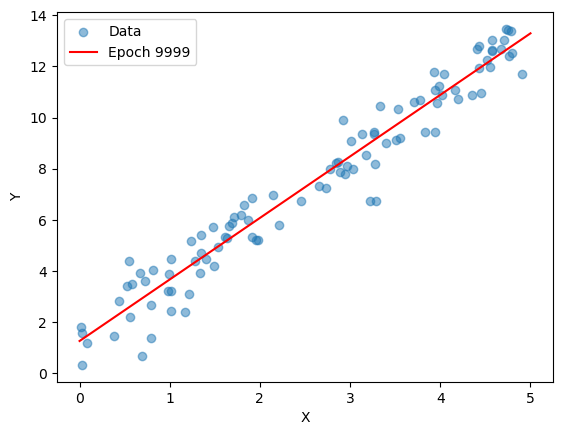

True Slope: 2.5, Learned Slope: 2.4068737030029297
True Intercept: 1.0, Learned Intercept: 1.2294565439224243


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# Generate some synthetic data
torch.manual_seed(42)
X = torch.rand(100, 1) * 5
true_slope = 2.5
true_intercept = 1.0
y = true_slope * X + true_intercept + torch.randn_like(X)


# Define Bayesian Linear Regression model
class BayesianLinearRegression(nn.Module):
    def __init__(self):
        super(BayesianLinearRegression, self).__init__()
        self.weight_mu = nn.Parameter(torch.randn(1))
        self.weight_rho = nn.Parameter(torch.randn(1))
        self.bias_mu = nn.Parameter(torch.randn(1))
        self.bias_rho = nn.Parameter(torch.randn(1))
        self.normal = Normal(0, 1)

    def forward(self, x):
        weight_epsilon = self.normal.sample(self.weight_mu.size())
        bias_epsilon = self.normal.sample(self.bias_mu.size())
        weight = self.weight_mu + torch.log(1 + torch.exp(self.weight_rho)) * weight_epsilon
        bias = self.bias_mu + torch.log(1 + torch.exp(self.bias_rho)) * bias_epsilon
        return x * weight + bias


# SVI for Bayesian Linear Regression with Jupyter visualization
def svi_bayesian_regression_visualize_jupyter(model, X, y, num_epochs=10000, lr=0.01, update_interval=100):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # Forward pass
        y_pred = model(X)

        # Compute negative log-likelihood as the loss
        log_likelihood = -Normal(y_pred, 0.1).log_prob(y).sum()
        kl_divergence = 0.5 * torch.sum(
            1 + torch.log(1e-8 + torch.exp(2 * model.weight_rho)) - model.weight_mu.pow(2) - torch.exp(
                2 * model.weight_rho))
        kl_divergence += 0.5 * torch.sum(
            1 + torch.log(1e-8 + torch.exp(2 * model.bias_rho)) - model.bias_mu.pow(2) - torch.exp(2 * model.bias_rho))
        loss = log_likelihood + kl_divergence

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % update_interval == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')
            plt.scatter(X.numpy(), y.numpy(), label='Data', alpha=0.5)

            # Plot the learned regression line
            x_values = torch.linspace(0, 5, 100).view(-1, 1)
            y_values = model(x_values).detach().numpy()
            plt.plot(x_values.numpy(), y_values, label=f'Epoch {epoch}', color='red')

            plt.xlabel('X')
            plt.ylabel('Y')
            plt.legend()
            plt.show()


# Instantiate the Bayesian Linear Regression model
bayesian_model = BayesianLinearRegression()

# Train the model using SVI with visualization suitable for Jupyter
svi_bayesian_regression_visualize_jupyter(bayesian_model, X, y)

# Get the learned parameters
learned_slope = bayesian_model.weight_mu.item()
learned_intercept = bayesian_model.bias_mu.item()

print(f'True Slope: {true_slope}, Learned Slope: {learned_slope}')
print(f'True Intercept: {true_intercept}, Learned Intercept: {learned_intercept}')
